### *Imports*

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pdb
import numpy as np
from scipy.spatial import ConvexHull
import numpy.matlib as matlib
from numpy.linalg import matrix_rank
import matplotlib.pyplot as plt
from shapely.geometry import box, MultiPolygon, Polygon, LineString, Point
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon as pl
from matplotlib import collections  as mc
!pip install gurobipy
import gurobipy as gp
from gurobipy import GRB
from gurobipy import *
from tqdm import trange
import time
import seaborn as sns
import pandas as pd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 96.8 MB/s eta 0:00:00


In [ ]:
import os
import cvxpy as cp
import pickle
import numpy as np
import pdb
import time
import random
import sys
import torch
import torch.nn as nn

import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn import Sigmoid
from datetime import datetime
import itertools

!pip install gurobipy  # install gurobipy, if not already installed
import gurobipy as gp
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Importing the data

First, let's get our features

In [ ]:
# Loading the data
data = np.load("drive/MyDrive/MIP/Receding + learning/19.12/data_simple.npz")
print(data['X'].shape)
print(data['Y'].shape)
print(data['U'].shape)
print(data['solve_times'].shape)
print(data['V'].shape)
print(data['param_x0y0'].shape)

(500000, 2, 3)
(500000, 88, 3)
(500000, 2, 2)
(500000,)
(500000,)
(500000, 2)


In [ ]:
N = 22 # Number of obstacles
X_test, Y_test,  x0y0_test = data['X'][240000:250000, :, :], data['Y'][240000:250000, :, :], data['param_x0y0'][240000:250000, :]
n = len(x0y0_test)
x0y0_features = np.repeat(x0y0_test, repeats = N, axis = 0)

nums_obstacle = np.array(range(0,N))
print(nums_obstacle)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]


In [ ]:
nums_obstacle = torch.from_numpy(nums_obstacle)
one_hot_obs = F.one_hot(nums_obstacle, num_classes = N)

Selecting one feature:

In [ ]:
def get_features(starting_position, one_hot_obs):
  #starting position is a 1d matrix 1x2
  x0 = np.repeat(starting_position[0], repeats = N, axis = 0)
  y0 = np.repeat(starting_position[1], repeats = N, axis = 0)

  x0_torch = torch.from_numpy(x0).view(-1,1) # feature 1
  y0_torch = torch.from_numpy(y0).view(-1,1) # feature 2
  X = torch.hstack([x0_torch, y0_torch, one_hot_obs])
  return X             

In [ ]:
def select_features(X, i):
  features = X[(i*N):((i+1)*N),:]
  return features

## Loading the models

In [ ]:
class LinearClassifier(torch.nn.Module):
  def __init__(self, input_dim=2, output_dim=N, n_hidden = 50 ):
    super(LinearClassifier, self).__init__()
    self.fc1 = torch.nn.Linear(input_dim, n_hidden)
    self.fc2 = torch.nn.Linear(n_hidden, n_hidden)
    self.fc3 = torch.nn.Linear(n_hidden, output_dim)

  def forward(self, x):
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    x = F.relu(x)
    x = self.fc3(x)
    return x

In [ ]:
#This neural network is used to predict the strategies

class LinearClassifier2(torch.nn.Module):
  def __init__(self, input_dim=24, output_dim= 90, n_hidden = 256 ):  
    super(LinearClassifier2, self).__init__()
    self.fc1 = torch.nn.Linear(input_dim, n_hidden)
    self.fc2 = torch.nn.Linear(n_hidden, n_hidden)
    self.fc3 = torch.nn.Linear(n_hidden, output_dim)


  def forward(self, x):
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    x = F.relu(x)
    x = self.fc3(x)
    return x

In [ ]:
model_target = LinearClassifier()
model_strat = LinearClassifier2()

In [ ]:
checkpoint_strat = torch.load('drive/MyDrive/MIP/Receding + learning/19.12/pred_strategies.ckpt')
model_strat.load_state_dict(checkpoint_strat)

<All keys matched successfully>

In [ ]:
checkpoint_target = torch.load('drive/MyDrive/MIP/Receding + learning/19.12/pred_candidates.ckpt')
model_target.load_state_dict(checkpoint_target)

<All keys matched successfully>

## helpers

In [ ]:
# bunch of functions from previous files

def pol2ver(polygon):
    """
    pol2ver function gets the vertices from a polygon (shapely object).
    """
    xo, yo = polygon.exterior.xy
    vertices = np.array(list(set(list(zip(xo,yo)))))
    return vertices


def ver2con(V):
    """ 
    ver2con function maps vertices of a convex polygon
    to linear constraints stored in matrices A and b. And it works.
    """
    k = ConvexHull(V).vertices 
    u = np.roll(k,-1)

    k = np.vstack((k,u)).T
    c = np.mean(V[k[:,0]], axis = 0)

    V = V - matlib.repmat(c, V.shape[0],1)

    A = np.zeros((k.shape[0], V.shape[1]))
    A[:] = np.nan
    rc = 0

    for ix in range(k.shape[0]):
        F = V[k[ix]]
        if matrix_rank(F, 1e-5) == F.shape[0]:
            rc = rc+1
            A[rc-1,:] = np.linalg.solve(F,np.ones((F.shape[0])))

    A = A[0:rc,:]
    b = np.ones((A.shape[0], 1))
    b = b.T + A @ c

    return(A, b)



def map_def():

    map_x_min = -1.6
    map_x_max = 1.6
    map_y_min = -3.5
    map_y_max = 3.5
    map = [map_x_min, map_x_max, map_y_min, map_y_max]

    robot_radius = 0.2

    obstacles = []
    obstacles.append(LineString([(-1.498, 2.998), (0.001, 3.000)]))
    obstacles.append(LineString([(1.051, 3.001), (1.494, 3.000)]))
    obstacles.append(LineString([(1.494, 3.000), (1.493, 0.430)]))
    obstacles.append(LineString([(1.494, -0.374), (1.497, -2.998)]))
    obstacles.append(LineString([(0.002, -2.999), (1.497, -2.998)]))
    obstacles.append(LineString([(-1.498, -2.999), (-1.050, -2.999)]))
    obstacles.append(LineString([(-1.496,-0.500), (-1.498, -2.999)]))
    obstacles.append(LineString([(-1.496, 0.750), (-1.495, 0.299)]))
    obstacles.append(LineString([(-1.498, 2.998), (-1.498, 1.553)]))
    obstacles.append(LineString([(-0.481, 2.382), (0.879, 1.356)]))
    obstacles.append(LineString([(-1.498, 1.553), (-0.700, 1.551)]))
    obstacles.append(LineString([(1.018, 0.429), (1.493, 0.430)]))
    obstacles.append(LineString([(0.141, 1.040), (-0.269, 0.524)]))
    obstacles.append(LineString([(-1.496, 0.526), (-0.269, 0.524)]))
    obstacles.append(LineString([(-0.269, 0.524), (-0.261, -0.008)]))
    obstacles.append(LineString([(-0.261,-0.008), (0.480, -0.008)]))
    obstacles.append(LineString([(0.011, -0.008), (0.011, -0.486)]))
    obstacles.append(LineString([(-1.496, -0.859), (-0.492, -0.860)]))
    obstacles.append(LineString([(0.922, -0.613), (0.924, -2.093)]))
    obstacles.append(LineString([(0.260, -1.084), (0.260, -2.093)]))
    obstacles.append(LineString([(-0.665, -2.094), (0.924, -2.093)]))
    obstacles.append(LineString([(-0.685, -2.103), (-0.931, -2.414)]))

    dilated_obstacles = []
    area_obstacles = MultiPolygon()

    A_list = [] # List of matrices A for A * x <= b for each obstacle
    b_list = []

    for line in obstacles:

        dilated = line.buffer(0.025 + robot_radius, cap_style = 3,join_style = 2)
        dilated = dilated.minimum_rotated_rectangle
        dilated_obstacles.append(dilated)
        area_obstacles = area_obstacles.union(dilated)
        vertices = pol2ver(dilated)
        A, b = ver2con(vertices)
        A_list.append(-A) #minus to get the constraint to be outside the polygon
        b_list.append(-b)

    area_obstacles = area_obstacles.simplify(tolerance=0.05)

    obstacles_boundary = []
    for geom in area_obstacles.geoms:    
        xo, yo = geom.exterior.xy
        obstacles_boundary.append(list(zip(xo,yo)))

    return(map, area_obstacles, obstacles_boundary, dilated_obstacles, robot_radius, A_list, b_list)



def visible(a,b, polygon_obstacle, polygon_map):
    """
    visible function determines if the robot can travel
    between two points using a straigth line without leaving 
    the map or touch an obstacle

    :param a: origin point
    :param b: destination point
    :param polygon_obstacle: list of polygon representing the dilated obstacles
    :param polygon_map: polygon representing the dilated map

    :return visible: True if the line does not cross obstacles or leave map
                     False otherwise
    """
    visible = True
    line = LineString([a,b])
    for x in polygon_obstacle:
        within_obstacle = line.within(x)
        crosses_obstacle = line.crosses(x)
        if within_obstacle == True or crosses_obstacle == True:
            visible = False     
    in_map = polygon_map.contains(line)
    if in_map == False:
        visible = False
    return visible


def distance(a,b):
    """
    distance function compute the eucledean distance between two points

    :param a: first point
    :param b: second point

    :return dist: eucledean distance between points a and b
    """
    dist = np.linalg.norm(np.array(a)-np.array(b))
    return(dist)  


def vis_graph(end, area_obstacles, obstacles,polygon_obstacle,polygon_map):
    """
     vis_graph function computes the visibility graph based on the computer vision results

     :param end: point to reach
     :param obstacles: list of vertices of the obstacles
     :param polygon_obstacle: list of polygons of dilated obstacles
     :param polygon_map: polygon of the dilated map

     :return graph: dictionnary containing in the key the index of the vertex of interest 
                    and for the value, other vertices with distance that are valid paths
                    for the robot
     :return end_idx: index of the robot vertex in vertices list
     :return targets_idx_list: list of the indexes of the targets (based on vertices list)
     :return vertices: List of all vertices, robot position, vertices of obstacles, and targets
     """
    graph = {}
    end_idx = 0
    obstacles = [item for sublist in obstacles for item in sublist]

    vertices_with_rep = obstacles
    vertices = []
    for i in vertices_with_rep : 
        if i not in vertices and polygon_map.contains(Point(i)): 
           vertices.append(i)

    vertices= [end] +  vertices

    for vtx1_idx, vtx1 in enumerate(vertices):
        for vtx2_idx, vtx2 in enumerate(vertices):
            if vtx1_idx != vtx2_idx:
                if visible(vtx1,vtx2,polygon_obstacle,polygon_map)==True:
                    if vtx1_idx in graph :
                        graph[vtx1_idx].append([vtx2_idx,distance(vtx1,vtx2)])
                    else:
                        graph[vtx1_idx] = [(vtx2_idx,distance(vtx1,vtx2))]
                else:
                    if not(vtx1_idx in graph):
                        graph[vtx1_idx] = []

    return graph, end_idx, vertices

## Solving

In [ ]:
strategy_tuples = np.zeros((N+1,N))
strategy_tuples[1:N+1, :] = np.eye(N)
strategy_tuples

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,

### Mapping the prediction to real map infos 

In [ ]:
np.unique(data['V'][:10].round())

array([ 0.,  6., 10., 33., 34., 40., 42., 51.])

In [ ]:
# mapping of vertices predicted by model target
old_labels = np.unique(data['V'][:240000].round())
len(np.unique(data['V'][:240000].round()))
# We need to make these classes range from 0 to n
labels = np.array((range(len(old_labels))))
print(old_labels)
print(labels)

[ 0.  4.  6.  7. 10. 13. 16. 17. 21. 23. 24. 26. 33. 34. 40. 41. 42. 47.
 51. 52. 55. 56.]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]


In [ ]:
with open('drive/MyDrive/MIP/Receding + learning/19.12/strategy_mapping1912.pkl', 'rb') as f:
    strat_map_dict = pickle.load(f)

In [ ]:
def mapping_strat(class_strat, strat_map_dict):
  c = [strat_map_dict[x].tolist() for x in class_strat]
  return c

def mapping_waypoint(class_waypoint, old_labels, labels):
  for idx, label in enumerate(labels):
      if class_waypoint == label:
        waypoint = old_labels[idx]
        continue
  return int(waypoint)

## Select nearest obstacles

In [ ]:
def get_nearest_obstacles(x, y, dilated_obstacles):
  idx_list = []
  pos = Point(x, y)
  for idx, obs in enumerate(dilated_obstacles):
    if pos.distance(obs) < 0.5:                     # T*tau*umax 
      idx_list.append(idx)
  return idx_list

In [ ]:
def dijkstra_aglorithm(idx_end, visibility_graph):
    """
    This algorithm finds the shortest distance and the associated path from one vertex to another in a graph

    :param idx_start: index of the starting vertex
    :param idx_end: index of the ending vertex
    :param visibility_graph: a graph (python dictionnary where keys = vertices and value = connected vertices and the corresponding distance)

    :return distance_array[idx_end]: the shortest distance from the starting index to the ending in the visibility graph
    :return path: the path associated, which is a list of the indices of the vertices in the graph
    """

    #calulates the shortest distance from goal to all vertices
    nb_points = len(visibility_graph)
    distance_array = np.full(nb_points, np.Inf, dtype=np.double) #creates an array to store distance to start
    distance_array[idx_end] = 0
    explored_array = np.full(nb_points, False, dtype=bool) #keeps track of explored points
    explored_array[idx_end] = True
    exploring_idx = idx_end #from where we are exploring


    while(not all(explored_array)):
        for vertices in visibility_graph[exploring_idx]:
            if distance_array[exploring_idx] + vertices[1] < distance_array[vertices[0]]:
                distance_array[vertices[0]] = distance_array[exploring_idx] + vertices[1]  # replace shortest distance
        temp_idx = np.argmin(distance_array[np.logical_not(explored_array)]) # 
        exploring_idx = np.arange(nb_points)[np.logical_not(explored_array)][temp_idx]
        explored_array[exploring_idx] = True

    return distance_array

### Solving a problem

In [ ]:
def solve_mip(A_list, b_list, start_x, start_y, vertices, waypoint, bin_seq, idx_list, T=3, tau=0.5):
    """
    solve_mip funtion uses Gurobi to solve a Mixed Integer Programming problem

    :param A_list:
    :param b_list:
    :param start_x:
    :param start_y:
    :param distance_array:
    :param vertices:
    :param ax:

    :return X_traj:
    :return Y_traj:
    :return U_traj:
    :return cost:
    :return X_traj[0,T-1]:
    :return X_traj[1, T-1]:
    :return ax:
    """

    # Create a new model
    m = gp.Model("mip1")    
    m.Params.LogToConsole = 0

    matrices = list(zip(A_list, b_list))

    vertices = [(1.3, 0), (0.22629999959955574, 2.775300400132888), (-1.273, 2.7732999998665777), (-1.273, 1.777436796878307), 
            (-0.4744367986471415, 1.7754353853460945), (-0.47556461465390576, 1.3254367986471416), (0.7925268154524867, 0.6535258182258848), 
            (1.2680873475579675, 0.6545269982934754), (1.2689126318094666, 2.7755075246459935), (0.825492673865953, 2.776508472632322),
            (0.793474181774115, 0.20352681545248683), (-0.22315045130358135, -2.774150551973562), (1.2717427843022142, -2.7731506233878727),
            (1.268742906365112, -0.1492573877361853), (-1.2708200000864573, -0.2751801440287423), (-1.2711073500192538, -0.6342238850579837), 
            (-0.2667760081307915, -0.635224215079785), (-0.267224215079785, -1.0852239918692086), (-1.2714674939684347, -1.0842237495595584), 
            (-1.272819855913565, -2.774), (-0.8250000000000001, -2.774), (0.705, -0.23300000000000012), (0.23600000000000002, -0.23300000000000007), 
            (0.23600000000000002, -0.711), (-0.214, -0.711), (-0.214, -0.233), (-0.48600000000000004, -0.23299999999999998), 
            (-0.49064740779348837, 0.29936098457022353), (-1.270003064041172, 0.3006313279381904), (-1.269501662966406, 0.07449944321876684), 
            (-1.2714994432187667, 0.9754983370335938), (-1.2710008516779385, 0.7506335521200315), (-0.37745968438862365, 0.7491770872996739), 
            (0.10481192590556132, 1.3561335529382093), (0.4571335529382091, 1.0761880740944387), (-0.04281640787757587, 0.4469827575555483), 
            (-0.03935802054591348, 0.21700000000000008), (0.705, 0.217), (-0.7961255394915645, 2.3378877073804762), 
            (-0.5251122926195231, 2.697125539491564), (1.1941255394915646, 1.4001122926195235), (0.9231122926195231, 1.0408744605084352),
            (1.1491415539057397, -2.317858356982588), (-0.5689280242231287, -2.3189395839040032), (-0.8941176571865752, -2.7300533068781165), 
            (-1.2470533068781164, -2.4508823428134248), (-0.8900594776107655, -1.9995608757315297), (-0.8901415539057398, -1.8691416430174121),
            (-0.7218823428134248, -1.7869466931218836), (-0.6181855865608905, -1.868970493887554), (0.035, -1.8685594268097938),
            (0.035, -0.8590000000000001), (0.485, -0.8590000000000001), (0.485, -1.8682762298305617), (0.6986959320518029, -1.8681417452918256),
            (0.6966961516652167, -0.38830425921807726), (1.1466957407819227, -0.3876961516652168)]

  
    matrices = [(np.array([[ 1.02616565e+00,  1.36913362e-03],
       [-5.92987390e-03,  4.44444049e+00],
       [-1.02616565e+00, -1.36913362e-03],
       [ 5.92987390e-03, -4.44444049e+00]]), np.array([[ -1.76397896,  12.33331554,  -0.23602104, -14.33331554]])), (np.array([[ 2.23963312, -0.00505561],
       [ 0.01003258,  4.44443312],
       [-2.23963312,  0.00505561],
       [-0.01003258, -4.44443312]]), np.array([[  1.8347638 ,  12.34828804,  -3.8347638 , -14.34828804]])), (np.array([[ 2.57685433e-04,  6.62251563e-01],
       [-4.44444411e+00,  1.72935568e-03],
       [-2.57685433e-04, -6.62251563e-01],
       [ 4.44444411e+00, -1.72935568e-03]]), np.array([[ 0.13614628, -7.63481143, -2.13614628,  5.63481143]])), (np.array([[ 4.44444154e+00,  5.08129749e-03],
       [-7.43845997e-04,  6.50617299e-01],
       [-4.44444154e+00, -5.08129749e-03],
       [ 7.43845997e-04, -6.50617299e-01]]), np.array([[ 5.63809526, -2.09805319, -7.63809526,  0.09805319]])), (np.array([[ 1.02827723e+00,  6.87810855e-04],
       [-2.97287187e-03,  4.44444345e+00],
       [-1.02827723e+00, -6.87810855e-04],
       [ 2.97287187e-03, -4.44444345e+00]]), np.array([[ -0.23136862, -14.32889185,  -1.76863138,  12.32889185]])), (np.array([[ 0.00000000e+00, -4.44444444e+00],
       [ 2.22717149e+00,  2.46716228e-16],
       [ 0.00000000e+00,  4.44444444e+00],
       [-2.22717149e+00, -0.00000000e+00]]), np.array([[ 12.32888889,  -3.83741648, -14.32888889,   1.83741648]])), (np.array([[ 4.44444302e+00, -3.55697721e-03],
       [ 5.42773587e-04,  6.78195597e-01],
       [-4.44444302e+00,  3.55697721e-03],
       [-5.42773587e-04, -6.78195597e-01]]), np.array([[-7.64710827, -2.18731573,  5.64710827,  0.18731573]])), (np.array([[ 4.44443352,  0.00985462],
       [-0.00492184,  2.21974764],
       [-4.44443352, -0.00985462],
       [ 0.00492184, -2.21974764]]), np.array([[-7.64148158,  0.17161824,  5.64148158, -2.17161824]])), (np.array([[ 0.        ,  1.05540897],
       [-4.44444444, -0.        ],
       [-0.        , -1.05540897],
       [ 4.44444444,  0.        ]]), np.array([[ 1.40158311,  5.65777778, -3.40158311, -7.65777778]])), (np.array([[ 2.67667404,  3.54802797],
       [-0.74136682,  0.55929585],
       [-2.67667404, -3.54802797],
       [ 0.74136682, -0.55929585]]), np.array([[ 6.16392241, -0.10220806, -8.16392241, -1.89779194]])), (np.array([[ 1.11389235e-02,  4.44443049e+00],
       [-1.60255585e+00,  4.01643070e-03],
       [-1.11389235e-02, -4.44443049e+00],
       [ 1.60255585e+00, -4.01643070e-03]]), np.array([[ 5.88551444,  0.76744238, -7.88551444, -2.76744238]])), (np.array([[ 0.0093567 , -4.4444346 ],
       [ 2.16215491,  0.00455191],
       [-0.0093567 ,  4.4444346 ],
       [-2.16215491, -0.00455191]]), np.array([[-2.89713732,  1.71654053,  0.89713732, -3.71654053]])), (np.array([[ 3.47971977, -2.76489362],
       [ 1.12185599,  1.41189681],
       [-3.47971977,  2.76489362],
       [-1.12185599, -1.41189681]]), np.array([[-3.38484887,  0.03230452,  1.38484887, -2.03230452]])), (np.array([[ 1.19260310e+00, -1.94393333e-03],
       [ 7.24439860e-03,  4.44443854e+00],
       [-1.19260310e+00,  1.94393333e-03],
       [-7.24439860e-03, -4.44443854e+00]]), np.array([[-2.0534928 ,  1.32693705,  0.0534928 , -3.32693705]])), (np.array([[ 4.44394202,  0.0668262 ],
       [-0.03062113,  2.03630492],
       [-4.44394202, -0.0668262 ],
       [ 0.03062113, -2.03630492]]), np.array([[-2.16040348, -0.46651873,  0.16040348, -1.53348127]])), (np.array([[ 5.59306310e-16,  4.44444444e+00],
       [-1.67926113e+00, -0.00000000e+00],
       [-3.72870873e-16, -4.44444444e+00],
       [ 1.67926113e+00, -2.46716228e-16]]), np.array([[-1.03555556, -1.18387909, -0.96444444, -0.81612091]])), (np.array([[ 0.        ,  2.15517241],
       [-4.44444444, -0.        ],
       [-0.        , -2.15517241],
       [ 4.44444444,  0.        ]]), np.array([[-1.53232759, -1.04888889, -0.46767241, -0.95111111]])), (np.array([[ 4.42673530e-03,  4.44444224e+00],
       [-1.37551467e+00,  1.37003453e-03],
       [-4.42673530e-03, -4.44444224e+00],
       [ 1.37551467e+00, -1.37003453e-03]]), np.array([[-4.82439828,  0.36608403,  2.82439828, -2.36608403]])), (np.array([[ 4.44444039e+00,  6.00600052e-03],
       [-1.40036184e-03,  1.03626776e+00],
       [-4.44444039e+00, -6.00600052e-03],
       [ 1.40036184e-03, -1.03626776e+00]]), np.array([[ 3.09409236, -2.40336281, -5.09409236,  0.40336281]])), (np.array([[-4.93432455e-16,  1.37080192e+00],
       [-4.44444444e+00, -0.00000000e+00],
       [-4.93432455e-16, -1.37080192e+00],
       [ 4.44444444e+00,  0.00000000e+00]]), np.array([[-3.17751885, -2.15555556,  1.17751885,  0.15555556]])), (np.array([[ 9.80872631e-01,  6.17289258e-04],
       [-2.79700665e-03,  4.44444356e+00],
       [-9.80872631e-01, -6.17289258e-04],
       [ 2.79700665e-03, -4.44444356e+00]]), np.array([[ -0.87426929, -10.30480481,  -1.12573071,   8.30480481]])), (np.array([[ 3.48578419, -2.75724409],
       [ 1.46569887,  1.85297703],
       [-3.48578419,  2.75724409],
       [-1.46569887, -1.85297703]]), np.array([[ 2.41072215, -6.36923332, -4.41072215,  4.36923332]]))]

    if idx_list == None:
      matrices = []
    else:
      matrices = [matrices[i] for i in idx_list]

    # Constraints on command
    u_max = 0.5  # [m/s]
    u_min = -0.5  # [m/s]

    # big M
    M = 1000

    # Create variables
    x = m.addVars(T ,lb=-1.6 ,ub =1.6 , vtype=GRB.CONTINUOUS, name="x")
    y = m.addVars(T ,lb=-3 ,ub=3 , vtype=GRB.CONTINUOUS, name="y")

    ux = m.addVars(T, lb=u_min, ub=u_max, vtype=GRB.CONTINUOUS, name="ux")
    uy = m.addVars(T, lb=u_min, ub=u_max, vtype=GRB.CONTINUOUS, name="uy")

    # Objective function
    expr = gp.QuadExpr()
    expr += (vertices[waypoint][1] - y[T-1])**2  +(vertices[waypoint][0] - x[T-1])**2 

    # Set objective
    m.setObjective(expr, GRB.MINIMIZE)

    # Initial constraints
    m.addConstr(x[0] == start_x,  name="initx")
    m.addConstr(y[0] == start_y,  name="inity")

    # System dynamics
    m.addConstrs((x[i] + tau*ux[i] == x[i+1] for i in range(T-1)),"c1")
    m.addConstrs((y[i] + tau*uy[i] == y[i+1] for i in range(T-1)),"c2")
    m.addConstrs((ux[i]**2 + uy[i]**2 <= 0.25 for i in range(T-1)),"c3")

    bin_variables = []

    for idx, (A, b) in enumerate(matrices): # use one set of binaries per obstacle
        #print(bin_seq[idx])
        for i in range (A.shape[0]):

          namec = "matrix: " + str(idx) + " line: " + str(i)
          m.addConstr((A[i,0]*x[0] + A[i,1]*y[0] <= b[0][i] - 0.001 + M*bin_seq[idx][i*(T) + (0)] ), name = namec )
          m.addConstr((A[i,0]*x[1] + A[i,1]*y[1] <= b[0][i] - 0.001 + M*bin_seq[idx][i*(T) + (1)] ), name = namec )
          m.addConstr((A[i,0]*x[2] + A[i,1]*y[2] <= b[0][i] - 0.001 + M*bin_seq[idx][i*(T) + (2)] ), name = namec )

    # Optimize model
    m.optimize()
    m.write('model.mps')

    X_traj = np.zeros((2,T))                       # to store positions
    Y_traj = np.zeros((4*len(matrices),(T)))       # to store binaries
    U_traj = np.zeros((2,T))

    if m.Status == GRB.OPTIMAL:

      for i in range(T):
          X_traj[0,i] = x[i].X
          X_traj[1,i] = y[i].X
          U_traj[0,i] = ux[i].X
          U_traj[1,i] = uy[i].X

      obj = m.getObjective()
      cost = obj.getValue()
      return (X_traj, Y_traj, U_traj, cost)

    else:
        return(None, None, None, None)

In [ ]:
# Get features
# Solve problems

xend, yend = 1.3, 0      # This position is fixed
T=3
tau = 0.5
umax = 0.5

map, area_obstacles, obstacles_boundary, dilated_obstacles, robot_radius, A_list, b_list = map_def()
#graph, end_idx, vertices = vis_graph((xend,yend), area_obstacles, obstacles_boundary, dilated_obstacles, Polygon(box(-1.6, -3.5, 1.6, 3.5)))
#distance_array = dijkstra_aglorithm(end_idx, graph)

vertices = [(1.3, 0), (0.22629999959955574, 2.775300400132888), (-1.273, 2.7732999998665777), (-1.273, 1.777436796878307), 
            (-0.4744367986471415, 1.7754353853460945), (-0.47556461465390576, 1.3254367986471416), (0.7925268154524867, 0.6535258182258848), 
            (1.2680873475579675, 0.6545269982934754), (1.2689126318094666, 2.7755075246459935), (0.825492673865953, 2.776508472632322),
            (0.793474181774115, 0.20352681545248683), (-0.22315045130358135, -2.774150551973562), (1.2717427843022142, -2.7731506233878727),
            (1.268742906365112, -0.1492573877361853), (-1.2708200000864573, -0.2751801440287423), (-1.2711073500192538, -0.6342238850579837), 
            (-0.2667760081307915, -0.635224215079785), (-0.267224215079785, -1.0852239918692086), (-1.2714674939684347, -1.0842237495595584), 
            (-1.272819855913565, -2.774), (-0.8250000000000001, -2.774), (0.705, -0.23300000000000012), (0.23600000000000002, -0.23300000000000007), 
            (0.23600000000000002, -0.711), (-0.214, -0.711), (-0.214, -0.233), (-0.48600000000000004, -0.23299999999999998), 
            (-0.49064740779348837, 0.29936098457022353), (-1.270003064041172, 0.3006313279381904), (-1.269501662966406, 0.07449944321876684), 
            (-1.2714994432187667, 0.9754983370335938), (-1.2710008516779385, 0.7506335521200315), (-0.37745968438862365, 0.7491770872996739), 
            (0.10481192590556132, 1.3561335529382093), (0.4571335529382091, 1.0761880740944387), (-0.04281640787757587, 0.4469827575555483), 
            (-0.03935802054591348, 0.21700000000000008), (0.705, 0.217), (-0.7961255394915645, 2.3378877073804762), 
            (-0.5251122926195231, 2.697125539491564), (1.1941255394915646, 1.4001122926195235), (0.9231122926195231, 1.0408744605084352),
            (1.1491415539057397, -2.317858356982588), (-0.5689280242231287, -2.3189395839040032), (-0.8941176571865752, -2.7300533068781165), 
            (-1.2470533068781164, -2.4508823428134248), (-0.8900594776107655, -1.9995608757315297), (-0.8901415539057398, -1.8691416430174121),
            (-0.7218823428134248, -1.7869466931218836), (-0.6181855865608905, -1.868970493887554), (0.035, -1.8685594268097938),
            (0.035, -0.8590000000000001), (0.485, -0.8590000000000001), (0.485, -1.8682762298305617), (0.6986959320518029, -1.8681417452918256),
            (0.6966961516652167, -0.38830425921807726), (1.1466957407819227, -0.3876961516652168)]



solved = 0
failed = 0
times_pred = []
times_solve = []
costs = []
times_select_obstacles = []

idx_list_mean = []
solved = []
xlists = []

waypoint_list = []
waypoint_indices = []
obs_list = []


for k in trange(x0y0_test.shape[0]):

  # starting point
  xlast = x0y0_test[k,0]
  ylast = x0y0_test[k,1]
  X_target = torch.Tensor([xlast, ylast])

  # ---------- prediction of the waypoint--------------
  t_pred = time.time()
  scores_waypoint = F.softmax(model_target(X_target.float())).cpu().detach().numpy()[:]
  waypoint = mapping_waypoint(int(np.argmax(scores_waypoint)), old_labels, labels)
  waypoint_list.append(vertices[waypoint])
  waypoint_indices.append(waypoint)

  #------------ prediction of the strategy------------
  X = get_features([xlast, ylast], one_hot_obs)
  scores = F.softmax(model_strat(X.float())).cpu().detach().numpy()[:]
  t_pred = time.time()-t_pred
  times_pred.append(t_pred)

  # ----------getting only the scores of nearby obstacles-----------
  t_obs = time.time()
  idx_list = get_nearest_obstacles(xlast, ylast, dilated_obstacles)
  times_select_obstacles.append(time.time()-t_obs)
  idx_list_mean.append(len(idx_list))
  scores = scores[idx_list, :]
  sorted_scores = np.argsort(scores, axis=1)[:, -2:][:,::-1]

  #--------------creating stategy tuples------------------
  tup = np.zeros(len(idx_list)) 
  # first strategy (first test that!)
  predicted_binaries = [sorted_scores[i,int(tup[i])] for i in range(len(tup))]

  # Now we get few most likely strategies :
  bin_seq = mapping_strat(predicted_binaries, strat_map_dict)

  #print(bin_seq)

  t_solve = time.time()
  X_traj, Y_traj, U_traj, cost = solve_mip(A_list, b_list, xlast, ylast, vertices, waypoint, bin_seq, idx_list)
  t_solve = time.time() - t_solve

  times_solve.append(t_solve)

  if X_traj is not None :
    solved.append(True)
    #costs.append(cost + Cvis**2)
    xlists.append(X_traj)
    obs_list.append(len(idx_list))
  else:
    solved.append(False)
    costs.append(None)
    xlists.append(None)
    obs_list.append(len(idx_list))




  0%|          | 0/10000 [00:00<?, ?it/s]

Restricted license - for non-production use only - expires 2024-10-28


<ipython-input-23-6b7565705db8>:65: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  scores_waypoint = F.softmax(model_target(X_target.float())).cpu().detach().numpy()[:]
<ipython-input-23-6b7565705db8>:83: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  scores = F.softmax(model_strat(X.float())).cpu().detach().numpy()[:]
100%|██████████| 10000/10000 [01:04<00:00, 155.67it/s]


# Performance

In [ ]:
solved.count(True)

8841

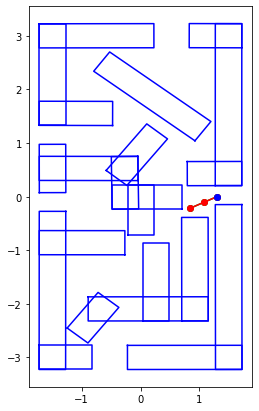

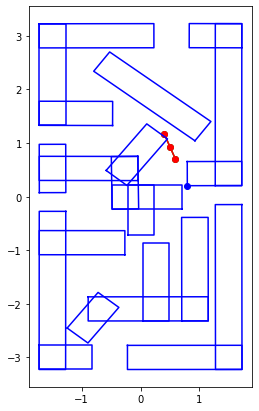

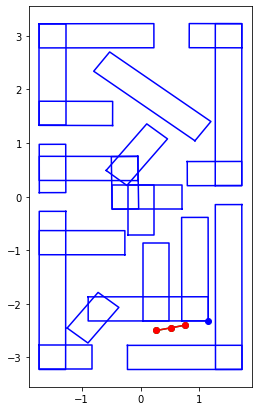

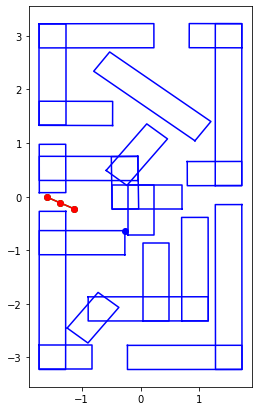

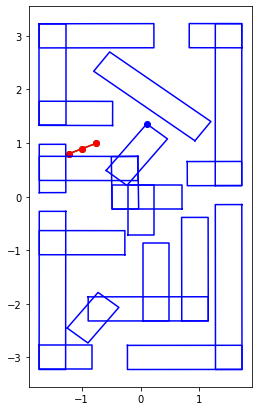

TypeError: ignored

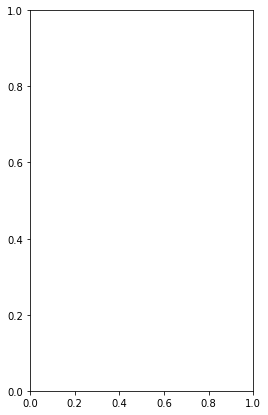

In [ ]:
for i in range (50):

  fig,ax = plt.subplots(figsize=(4,7))
  plt.plot(xlists[i][0,:], xlists[i][1,:], color = 'green', marker = 'o')
  plt.plot(data['X'][240000+i][0,:], data['X'][240000+i][1,:], color = 'red', marker = 'o')
  plt.plot(waypoint_list[i][0], waypoint_list[i][1] , color = 'blue', marker = 'o')

  obstacles = []
  obstacles.append(LineString([(-1.498, 2.998), (0.001, 3.000)]))
  obstacles.append(LineString([(1.051, 3.001), (1.494, 3.000)]))
  obstacles.append(LineString([(1.494, 3.000), (1.493, 0.430)]))
  obstacles.append(LineString([(1.494, -0.374), (1.497, -2.998)]))
  obstacles.append(LineString([(0.002, -2.999), (1.497, -2.998)]))
  obstacles.append(LineString([(-1.498, -2.999), (-1.050, -2.999)]))
  obstacles.append(LineString([(-1.496,-0.500), (-1.498, -2.999)]))
  obstacles.append(LineString([(-1.496, 0.750), (-1.495, 0.299)]))
  obstacles.append(LineString([(-1.498, 2.998), (-1.498, 1.553)]))
  obstacles.append(LineString([(-0.481, 2.382), (0.879, 1.356)]))
  obstacles.append(LineString([(-1.498, 1.553), (-0.700, 1.551)]))
  obstacles.append(LineString([(1.018, 0.429), (1.493, 0.430)]))
  obstacles.append(LineString([(0.141, 1.040), (-0.269, 0.524)]))
  obstacles.append(LineString([(-1.496, 0.526), (-0.269, 0.524)]))
  obstacles.append(LineString([(-0.269, 0.524), (-0.261, -0.008)]))
  obstacles.append(LineString([(-0.261,-0.008), (0.480, -0.008)]))
  obstacles.append(LineString([(0.011, -0.008), (0.011, -0.486)]))
  obstacles.append(LineString([(-1.496, -0.859), (-0.492, -0.860)]))
  obstacles.append(LineString([(0.922, -0.613), (0.924, -2.093)]))
  obstacles.append(LineString([(0.260, -1.084), (0.260, -2.093)]))
  obstacles.append(LineString([(-0.665, -2.094), (0.924, -2.093)]))
  obstacles.append(LineString([(-0.685, -2.103), (-0.931, -2.414)]))
  for line in obstacles:
          dilated = line.buffer(0.025 + robot_radius, cap_style = 3,join_style = 2)
          
          dilated = dilated.minimum_rotated_rectangle

          dilated_obstacles.append(dilated)
          area_obstacles = area_obstacles.union(dilated)
          # ax.plot(line.xy[0], line.xy[1])
          x,y = dilated.exterior.xy
          plt.plot(x,y, 'b')
  plt.show()

  time.sleep(3)



In [ ]:
data['X']

array([[[-0.52603651, -0.36959511, -0.21315104],
        [-1.55813594, -1.36313315, -1.16813251]],

       [[ 1.2297399 ,  1.09605778,  0.9623986 ],
        [ 1.3447214 ,  1.13346541,  0.92219492]],

       [[ 0.24207174,  0.46982414,  0.697578  ],
        [-2.72823193, -2.62513572, -2.52204274]],

       ...,

       [[ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ]],

       [[ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ]],

       [[ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ]]])

In [ ]:
# value at the last timestep
last_xy = [value[:,T-1] if value is not None else np.array([None, None]) for value in xlists]

In [ ]:
first_x_y = [value[:, 0] if value is not None else np.array([None, None]) for value in xlists]

In [ ]:
m = [last_xy[k][0] for k in range(100)]
n = [last_xy[k][1] for k in range(100)]

In [ ]:
print(data['X'][240000:240100,:,-1].shape)
ref_xy = data['X'][240000:240100,:,-1]
start_xy = data['X'][240000:240100,:,0]

(100, 2)


In [ ]:
count = 100
o = [ref_xy[k][0] for k in range(count)]
p = [ref_xy[k][1] for k in range(count)]
q = [start_xy[k][0] for k in range(count)]
r = [start_xy[k][1] for k in range(count)]
qb = [first_x_y[k][0] for k in range(count)]
rb = [first_x_y[k][1] for k in range(count)]
s = [waypoint_list[k][0] for k in range(count)]
t = [waypoint_list[k][1] for k in range(count)]
u = waypoint_indices
v = data['V'][240000:240100]
w = obs_list

In [ ]:
df_last_pos = pd.DataFrame(list(zip(m,n,o,p,q,r, qb, rb,s,t,u,v, w)), columns = ['lastx', 'lasty', 'refx', 'refy', 'startx', 'starty', 'startx_bis', 'starty_bis','xvis', 'yvis', 'wp index', 'wp_ref', 'num_obs'])
df_last_pos

,lastx,lasty,refx,refy,startx,starty,startx_bis,starty_bis,xvis,yvis,wp index,wp_ref,num_obs
0,1.294599,-0.002602,1.294621,-0.002549,0.842555,-0.216176,0.842555,-0.216176,1.300000,0.000000,0,0.0,4
1,0.592556,0.697096,0.592554,0.697094,0.404742,1.160481,0.404742,1.160481,0.793474,0.203527,10,10.0,2
2,0.758858,-2.397220,0.758872,-2.397280,0.268874,-2.496784,0.268874,-2.496784,1.149142,-2.317858,42,42.0,4
3,-1.136418,-0.224687,-1.136298,-0.224431,-1.588498,-0.011088,-1.588498,-0.011088,-0.266776,-0.635224,16,16.0,3
4,-0.759028,0.991890,-0.759015,0.991859,-1.219787,0.797722,-1.219787,0.797722,0.104812,1.356134,33,33.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,NaN,NaN,1.060290,-2.411260,0.714078,-2.772003,NaN,NaN,1.149142,-2.317858,42,42.0,3
96,NaN,NaN,0.725518,0.217841,0.236188,0.320582,NaN,NaN,0.793474,0.203527,10,10.0,5
97,0.693110,1.983477,0.692813,1.983221,0.367345,2.362787,0.367345,2.362787,1.194126,1.400112,40,40.0,2
98,-0.753503,-0.588412,-0.753486,-0.588214,-1.251229,-0.540776,-1.251229,-0.540776,-0.266776,-0.635224,16,16.0,2


In [ ]:
df_last_pos['diffx'] = np.abs(df_last_pos.lastx-df_last_pos.refx)
df_last_pos['diffy'] = np.abs(df_last_pos.lasty-df_last_pos.refy)

df_last_pos['norm'] = np.sqrt((df_last_pos.lastx-df_last_pos.xvis)**2 + (df_last_pos.lasty-df_last_pos.yvis)**2)
df_last_pos['norm_ref'] = np.sqrt((df_last_pos.refx-df_last_pos.xvis)**2 + (df_last_pos.refy-df_last_pos.yvis)**2)
df_last_pos['diff_norm'] =  df_last_pos['norm']-df_last_pos['norm_ref']

df_last_pos.describe()

,lastx,lasty,refx,refy,startx,starty,startx_bis,starty_bis,xvis,yvis,wp index,wp_ref,num_obs,diffx,diffy,norm,norm_ref,diff_norm
count,91.000000,91.000000,100.000000,100.000000,100.000000,100.000000,91.000000,91.000000,100.000000,100.000000,100.000000,100.000000,100.00000,9.100000e+01,9.100000e+01,91.000000,100.000000,9.100000e+01
mean,0.187755,0.035074,0.213812,0.039148,-0.121504,0.091476,-0.148441,0.083600,0.582546,-0.042321,26.960000,27.270000,3.27000,4.716460e-03,4.101964e-03,0.546359,0.538347,1.759187e-03
std,0.745353,1.349316,0.743178,1.353900,0.825562,1.552938,0.822054,1.541471,0.600595,1.087131,16.331119,16.507638,1.10878,1.761581e-02,1.264399e-02,0.466153,0.459030,8.196442e-03
min,-1.136418,-2.784555,-1.136298,-2.784848,-1.588498,-2.941174,-1.588498,-2.941174,-0.890142,-2.317858,0.000000,0.000000,1.00000,5.399202e-09,2.055850e-09,0.000082,0.000000,-5.414480e-03
25%,-0.520618,-0.626195,-0.516857,-0.604965,-0.924757,-0.752214,-0.931714,-0.766875,0.035000,-0.711000,13.000000,13.000000,2.75000,2.142114e-05,4.553029e-05,0.188188,0.182978,-1.074796e-07
50%,0.104869,-0.004686,0.297769,-0.003492,-0.132303,-0.012677,-0.242552,-0.014266,0.705000,0.000000,33.000000,33.000000,3.00000,1.063538e-04,1.171768e-04,0.452471,0.444476,1.692476e-07
75%,0.792138,1.232033,0.792963,1.244850,0.522522,1.164840,0.507013,1.134677,1.194126,1.076188,40.000000,40.000000,4.00000,2.855248e-04,2.864237e-04,0.767826,0.767249,2.316524e-06
max,1.300003,2.426579,1.300000,2.426560,1.265091,2.880638,1.265091,2.880638,1.300000,1.400112,56.000000,56.000000,6.00000,1.146725e-01,6.108412e-02,1.765902,1.765902,5.984418e-02


In [ ]:
# Time to predict which obstacles to consider
print(np.mean(times_select_obstacles))
print(np.std(times_select_obstacles))

0.0003442596435546875
0.0003531308183791364


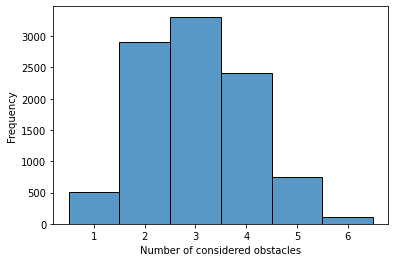

In [ ]:
sns.histplot(idx_list_mean, discrete = True)
#sns.histplot(df.groupby("number_of_obstacles")['solved'].sum(), discrete = True)
plt.xlabel('Number of considered obstacles')
plt.ylabel('Frequency')
plt.savefig('img.png',dpi=300, format = 'png', bbox_inches = 'tight')

In [ ]:
df = pd.DataFrame(list(zip(solved, idx_list_mean)), columns = ['solved', 'number_of_obstacles'])
df.head(5)

,solved,number_of_obstacles
0,True,4
1,True,2
2,True,4
3,True,3
4,True,2


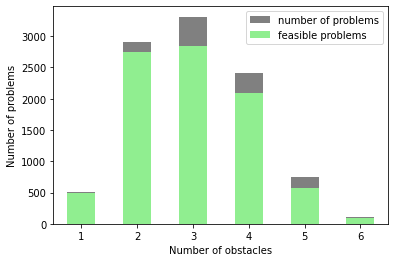

In [ ]:
groups = df.groupby("number_of_obstacles")['solved'].sum()
lengths = df.groupby("number_of_obstacles")['solved'].count()

lengths.plot(kind='bar', color = 'grey', label = 'number of problems')
groups.plot(kind='bar', color = 'lightgreen', label = 'feasible problems')

plt.xlabel('Number of obstacles')
plt.ylabel('Number of problems')
plt.legend()
plt.xticks(rotation = 0)
plt.savefig('img.png',dpi=300, format = 'png', bbox_inches = 'tight')



In [ ]:
groups

number_of_obstacles
1     494
2    2743
3    2843
4    2088
5     579
6      94
Name: solved, dtype: int64

In [ ]:
groups/df.groupby("number_of_obstacles")['solved'].count()

number_of_obstacles
1    0.986028
2    0.941964
3    0.858912
4    0.864238
5    0.774064
6    0.831858
Name: solved, dtype: float64

In [ ]:
# Time to solve the convex optimization problem
print(np.median(times_solve))
print(np.std(times_solve))


0.0043828487396240234
0.003987351759667004


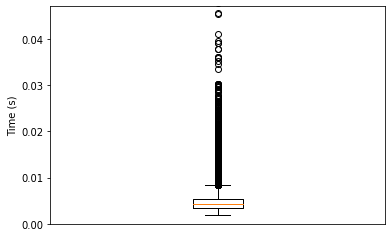

In [ ]:
# Mean solving time of the convex optimization problem
ax = plt.subplot()
ax.boxplot(times_solve)
plt.ylabel('Time (s)')
ax.axes.get_xaxis().set_visible(False)
plt.savefig('img.png',dpi=300, format = 'png', bbox_inches = 'tight')

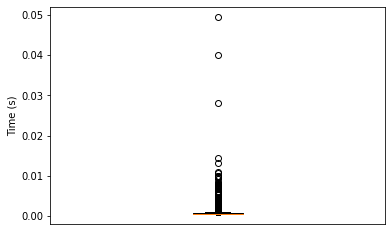

In [ ]:
# Mean prediction time (waypoint + binaries sequencies)
ax = plt.subplot()
ax.boxplot(times_pred)
plt.ylabel('Time (s)')
ax.axes.get_xaxis().set_visible(False)

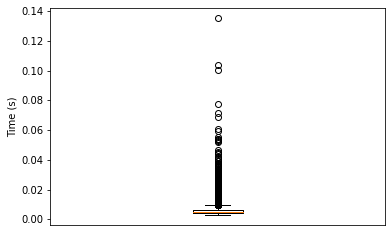

In [ ]:
ax = plt.subplot()
ax.boxplot([sum(x) for x in zip(times_solve, times_pred, times_select_obstacles)])
plt.ylabel('Time (s)')
ax.axes.get_xaxis().set_visible(False)

0.04699993133544922
0.005890085593967695


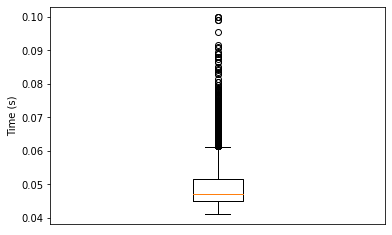

In [ ]:
# MIP solving times
mip_times = data['solve_times'][240000:250000]
ax = plt.subplot()
ax.boxplot(mip_times)
plt.ylabel('Time (s)')
ax.axes.get_xaxis().set_visible(False)
print(np.median(mip_times))
print(np.std(mip_times))
plt.savefig('img.png',dpi=300, format = 'png', bbox_inches = 'tight')

In [ ]:
print('The mean prediction time is: ' + str(np.mean(times_pred)))
print('The standard deviation is: ' + str(np.std(times_pred)))

The mean prediction time is: 0.000636173152923584
The standard deviation is: 0.0008763655900091667


# Solving the full problem

In [ ]:
# Get features
# Solve problems

xend, yend = 1.3, 0      # This position is fixed
T=3
tau = 0.5
umax = 0.5

map, area_obstacles, obstacles_boundary, dilated_obstacles, robot_radius, A_list, b_list = map_def()
#graph, end_idx, vertices = vis_graph((xend,yend), area_obstacles, obstacles_boundary, dilated_obstacles, Polygon(box(-1.6, -3.5, 1.6, 3.5)))
#distance_array = dijkstra_aglorithm(end_idx, graph)

vertices = [(1.3, 0), (0.22629999959955574, 2.775300400132888), (-1.273, 2.7732999998665777), (-1.273, 1.777436796878307), 
            (-0.4744367986471415, 1.7754353853460945), (-0.47556461465390576, 1.3254367986471416), (0.7925268154524867, 0.6535258182258848), 
            (1.2680873475579675, 0.6545269982934754), (1.2689126318094666, 2.7755075246459935), (0.825492673865953, 2.776508472632322),
            (0.793474181774115, 0.20352681545248683), (-0.22315045130358135, -2.774150551973562), (1.2717427843022142, -2.7731506233878727),
            (1.268742906365112, -0.1492573877361853), (-1.2708200000864573, -0.2751801440287423), (-1.2711073500192538, -0.6342238850579837), 
            (-0.2667760081307915, -0.635224215079785), (-0.267224215079785, -1.0852239918692086), (-1.2714674939684347, -1.0842237495595584), 
            (-1.272819855913565, -2.774), (-0.8250000000000001, -2.774), (0.705, -0.23300000000000012), (0.23600000000000002, -0.23300000000000007), 
            (0.23600000000000002, -0.711), (-0.214, -0.711), (-0.214, -0.233), (-0.48600000000000004, -0.23299999999999998), 
            (-0.49064740779348837, 0.29936098457022353), (-1.270003064041172, 0.3006313279381904), (-1.269501662966406, 0.07449944321876684), 
            (-1.2714994432187667, 0.9754983370335938), (-1.2710008516779385, 0.7506335521200315), (-0.37745968438862365, 0.7491770872996739), 
            (0.10481192590556132, 1.3561335529382093), (0.4571335529382091, 1.0761880740944387), (-0.04281640787757587, 0.4469827575555483), 
            (-0.03935802054591348, 0.21700000000000008), (0.705, 0.217), (-0.7961255394915645, 2.3378877073804762), 
            (-0.5251122926195231, 2.697125539491564), (1.1941255394915646, 1.4001122926195235), (0.9231122926195231, 1.0408744605084352),
            (1.1491415539057397, -2.317858356982588), (-0.5689280242231287, -2.3189395839040032), (-0.8941176571865752, -2.7300533068781165), 
            (-1.2470533068781164, -2.4508823428134248), (-0.8900594776107655, -1.9995608757315297), (-0.8901415539057398, -1.8691416430174121),
            (-0.7218823428134248, -1.7869466931218836), (-0.6181855865608905, -1.868970493887554), (0.035, -1.8685594268097938),
            (0.035, -0.8590000000000001), (0.485, -0.8590000000000001), (0.485, -1.8682762298305617), (0.6986959320518029, -1.8681417452918256),
            (0.6966961516652167, -0.38830425921807726), (1.1466957407819227, -0.3876961516652168)]



solved = 0
failed = 0
times_pred = []
times_solve = []
costs = []
times_select_obstacles = []
idx_list_mean = []
solved = []
xlists = []
waypoint_list = []
waypoint_indices = []
obs_list = []
xlist_total = []


for k in trange(x0y0_test.shape[0]):
  k = 0
  # starting point
  xlast = x0y0_test[k,0]
  ylast = x0y0_test[k,1]

  while np.sqrt((xlast-xend)**2 + (ylast-yend)**2) > 0.02:
    X_target = torch.Tensor([xlast, ylast])

    # ---------- prediction of the waypoint--------------
    t_pred = time.time()
    scores_waypoint = F.softmax(model_target(X_target.float())).cpu().detach().numpy()[:]
    waypoint = mapping_waypoint(int(np.argmax(scores_waypoint)), old_labels, labels)
    waypoint_list.append(vertices[waypoint])
    waypoint_indices.append(waypoint)

    #------------ prediction of the strategy------------
    #_, predicted_binaries = torch.max(F.softmax(model_strat(X_strat.float())),-1)
    X = get_features([xlast, ylast], one_hot_obs)
    scores = F.softmax(model_strat(X.float())).cpu().detach().numpy()[:]
    t_pred = time.time()-t_pred
    times_pred.append(t_pred)

    # ----------getting only the scores of nearby obstacles-----------
    t_obs = time.time()
    idx_list = get_nearest_obstacles(xlast, ylast, dilated_obstacles)
    times_select_obstacles.append(time.time()-t_obs)
    idx_list_mean.append(len(idx_list))
    scores = scores[idx_list, :]
    sorted_scores = np.argsort(scores, axis=1)[:, -2:][:,::-1]

    #--------------creating stategy tuples--------------------------
    tup = np.zeros(len(idx_list)) 
    predicted_binaries = [sorted_scores[i,int(tup[i])] for i in range(len(tup))]
    bin_seq = mapping_strat(predicted_binaries, strat_map_dict)

    #------------ solving the convex optimization------------------
    X_traj, Y_traj, U_traj, cost = solve_mip(A_list, b_list, xlast, ylast, vertices, waypoint, bin_seq, idx_list)
    times_solve.append(t_solve)
    xlast = X_traj[0, T-1]
    ylast = X_traj[1, T-1]

    if X_traj is not None :
      xlist_total.append(X_traj[:,0:T])
    else:
      break
  break


  0%|          | 0/10000 [00:00<?, ?it/s]<ipython-input-73-70898cc48852>:64: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  scores_waypoint = F.softmax(model_target(X_target.float())).cpu().detach().numpy()[:]
<ipython-input-73-70898cc48852>:82: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  scores = F.softmax(model_strat(X.float())).cpu().detach().numpy()[:]
  0%|          | 0/10000 [00:00<?, ?it/s]


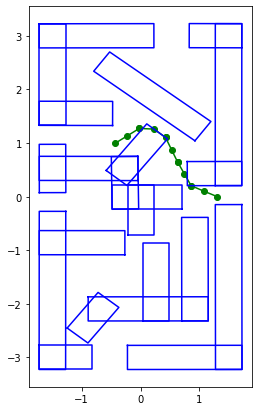

In [ ]:
for i in range (1):

  fig,ax = plt.subplots(figsize=(4,7))
  for k in range(len(xlist_total)):
    plt.plot(xlist_total[k][0], xlist_total[k][1], color = 'green', marker = 'o')
    
  obstacles = []
  obstacles.append(LineString([(-1.498, 2.998), (0.001, 3.000)]))
  obstacles.append(LineString([(1.051, 3.001), (1.494, 3.000)]))
  obstacles.append(LineString([(1.494, 3.000), (1.493, 0.430)]))
  obstacles.append(LineString([(1.494, -0.374), (1.497, -2.998)]))
  obstacles.append(LineString([(0.002, -2.999), (1.497, -2.998)]))
  obstacles.append(LineString([(-1.498, -2.999), (-1.050, -2.999)]))
  obstacles.append(LineString([(-1.496,-0.500), (-1.498, -2.999)]))
  obstacles.append(LineString([(-1.496, 0.750), (-1.495, 0.299)]))
  obstacles.append(LineString([(-1.498, 2.998), (-1.498, 1.553)]))
  obstacles.append(LineString([(-0.481, 2.382), (0.879, 1.356)]))
  obstacles.append(LineString([(-1.498, 1.553), (-0.700, 1.551)]))
  obstacles.append(LineString([(1.018, 0.429), (1.493, 0.430)]))
  obstacles.append(LineString([(0.141, 1.040), (-0.269, 0.524)]))
  obstacles.append(LineString([(-1.496, 0.526), (-0.269, 0.524)]))
  obstacles.append(LineString([(-0.269, 0.524), (-0.261, -0.008)]))
  obstacles.append(LineString([(-0.261,-0.008), (0.480, -0.008)]))
  obstacles.append(LineString([(0.011, -0.008), (0.011, -0.486)]))
  obstacles.append(LineString([(-1.496, -0.859), (-0.492, -0.860)]))
  obstacles.append(LineString([(0.922, -0.613), (0.924, -2.093)]))
  obstacles.append(LineString([(0.260, -1.084), (0.260, -2.093)]))
  obstacles.append(LineString([(-0.665, -2.094), (0.924, -2.093)]))
  obstacles.append(LineString([(-0.685, -2.103), (-0.931, -2.414)]))

  for line in obstacles:
          dilated = line.buffer(0.025 + robot_radius, cap_style = 3,join_style = 2)
          dilated = dilated.minimum_rotated_rectangle
          dilated_obstacles.append(dilated)
          area_obstacles = area_obstacles.union(dilated)
          x,y = dilated.exterior.xy
          plt.plot(x,y, 'b')
          
  plt.savefig('img.png',dpi=300, format = 'png', bbox_inches = 'tight')
  plt.show()
  time.sleep(3)